# 机器人自动走迷宫-程序报告

吴天宇 12334125

## 1 实验概要

### 1.1 实验内容
在本实验中，要求分别使用基础搜索算法和 Deep QLearning 算法，完成机器人自动走迷宫。

<img src="https://imgbed.momodel.cn/20200914145238.png" width="40%"/>

如上图所示，左上角的红色椭圆既是起点也是机器人的初始位置，右下角的绿色方块是出口。          
游戏规则为：从起点开始，通过错综复杂的迷宫，到达目标点(出口)。

+ 在任一位置可执行动作包括：向上走 `'u'`、向右走 `'r'`、向下走 `'d'`、向左走 `'l'`。

+ 执行不同的动作后，根据不同的情况会获得不同的奖励，具体而言，有以下几种情况：
    - 撞墙
    - 走到出口
    - 其余情况

### 1.2 实验结果概要

A* 算法利用启发式函数计算出当前节点到目标节点的估计代价，进而逐步扩展路径至终点。实验表明，A* 算法能够迅速找到从起点到终点的最短路径，在中小规模迷宫上表现出高效性。然而，由于需要广泛搜索，随着迷宫复杂度和规模增大，计算效率显著下降。此方法适用于环境已知的场景，但难以应对未知或动态迷宫环境。所以，A*算法适用于较小规模、结构稳定的迷宫，能保证最优解，但计算量随规模显著增加。

在DQN算法中，通过强化学习训练，机器人学习了在迷宫中的策略。DQN模型通过经验回放和目标网络实现稳定训练，模型损失值在训练过程中逐步收敛，最终学习到一条稳定的最优路径。实验显示，DQN在反复探索后能够自主找到最短路径，对大规模迷宫表现出较强的适应性。此外，DQN模型在遇到新迷宫或动态变化的迷宫时也能通过学习适应，展现了出色的灵活性。所以，DQN算法适用于大规模或动态迷宫，训练后能够快速找到出口，具备较强的泛化能力。

## 2 基于最佳优先搜索 A* 算法

本实验旨在使用 A* 搜索算法，编程实现机器人在迷宫中自动寻找从起点到终点的最短路径。A* 算法是一种启发式搜索算法，通过计算综合代价 f = g + h 来确定从起点到终点的最优路径，其中 g 表示实际路径代价，h 为曼哈顿距离启发式估计。算法从起点开始，依次选择 f 值最小的节点进行扩展，生成的子节点若未被访问则加入开放列表，并更新其 g 和 f 值。当找到目标节点时，通过回溯父节点重构路径。A算法在结构稳定的已知迷宫中表现优异，能够迅速找到最短路径，但在迷宫规模增大或环境动态变化时，计算量显著增加。以下是详细的代码实现和解释。

### 2.1 导入必要的库和模块

In [1]:
import os
import random
import numpy as np
from Maze import Maze  # 迷宫环境类
from Runner import Runner
from QRobot import QRobot
from ReplayDataSet import ReplayDataSet
from torch_py.MinDQNRobot import MinDQNRobot as TorchRobot  # PyTorch版本的机器人
#from keras_py.MinDQNRobot import MinDQNRobot as KerasRobot  # Keras版本的机器人
import matplotlib.pyplot as plt

/home/wuty/anaconda3/envs/zju_ai_sys/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2.2 定义移动方向字典

move_map 是一个字典，用于将动作（‘u’、‘r’、‘d’、‘l’）映射到相应的坐标变化，可以根据动作更新机器人在迷宫中的位置。

In [2]:
# ==================== 移动方向字典 ====================
move_map = {
    'u': (-1, 0),  # 向上移动，行坐标减1，列坐标不变
    'r': (0, 1),   # 向右移动，行坐标不变，列坐标加1
    'd': (1, 0),   # 向下移动，行坐标加1，列坐标不变
    'l': (0, -1)   # 向左移动，行坐标不变，列坐标减1
}

### 2.3 定义搜索树节点类

 + SearchTree 类表示搜索树中的一个节点，包含了位置、动作、父节点、子节点、实际代价 g 和评估函数值 f 等属性。

 + loc：节点在迷宫中的位置坐标。

 + to_this_action：从父节点到达当前节点所采取的动作。

 + parent：父节点对象。

 + children：子节点列表。

 + g：从起点到当前节点的实际代价，即路径长度。

 + f：评估函数值，f = g + h，其中 h 是启发式函数的估计代价。

 + add_child(child) 方法用于向当前节点添加子节点。

 + is_leaf() 方法用于判断当前节点是否为叶子节点（没有子节点）。

In [3]:
# ==================== 搜索树节点类 ====================
class SearchTree:
    def __init__(self, loc=(), action='', parent=None):
        """
        初始化搜索树节点对象。
        
        参数:
            loc (tuple): 当前节点的位置坐标 (x, y)。
            action (str): 到达该节点的动作（'u', 'r', 'd', 'l'）。
            parent (SearchTree): 该节点的父节点。
        """
        self.loc = loc                 # 当前节点的位置
        self.to_this_action = action   # 到达该节点的动作
        self.parent = parent           # 父节点
        self.children = []             # 子节点列表
        self.g = 0                     # 从起点到当前节点的实际代价（路径长度）
        self.f = 0                     # 启发式估值 f = g + h

    def add_child(self, child):
        """
        添加子节点。
        
        参数:
            child (SearchTree): 待添加的子节点。
        """
        self.children.append(child)

    def is_leaf(self):
        """
        判断当前节点是否是叶子节点（没有子节点）。
        
        返回:
            bool: 如果没有子节点，则返回 True。
        """
        return len(self.children) == 0

### 2.4 定义启发式函数

 + heuristic_manhattan 函数计算当前节点位置 curr 到目标节点位置 goal 的曼哈顿距离，用作启发式估计。

 + 曼哈顿距离是指在格子地图中，只能沿着水平方向和竖直方向移动时，从一个点到另一个点的最短路径长度。

In [4]:
# ==================== 启发式函数 ====================
def heuristic_manhattan(curr, goal):
    """
    计算当前位置到目标点的曼哈顿距离。
    
    参数:
        curr (tuple): 当前坐标 (x, y)。
        goal (tuple): 目标坐标 (x, y)。
    
    返回:
        int: 曼哈顿距离。
    """
    return abs(curr[0] - goal[0]) + abs(curr[1] - goal[1])

### 2.5 定义节点扩展函数

  + expand_a_star 函数用于扩展当前节点的所有可行子节点。

  + 首先获取当前节点可以采取的有效动作 valid_actions，即从当前位置可以移动到哪些方向而不撞墙。

  + 对于每一个有效动作，计算新的位置 new_loc。

  + 如果新的位置没有被访问过（不在 closed_set 中），则：

    + 计算从起点到新节点的实际代价 g_new，即当前节点的 g 值加1。

    + 使用启发式函数计算新节点到目标的估计代价 h_new。

    + 计算评估函数值 f_new = g_new + h_new。

    + 创建新节点 child，设置其位置、动作、父节点、g 值和 f 值。

    + 将新节点添加到开放列表 open_list 中，等待后续的扩展。

In [5]:
# ==================== 节点扩展函数 ====================
def expand_a_star(maze, closed_set, node, goal, open_list):
    """
    扩展当前节点的所有可行子节点，并将新节点加入 open_list。
    
    参数:
        maze (Maze): 迷宫对象。
        closed_set (set): 已访问节点的集合，防止重复搜索。
        node (SearchTree): 当前待扩展的节点。
        goal (tuple): 目标点坐标。
        open_list (list): 存放待扩展节点的开放列表。
    """
    # 获取从当前节点可以采取的有效动作
    valid_actions = maze.can_move_actions(node.loc)
    for a in valid_actions:
        # 计算新节点的位置
        new_loc = tuple(node.loc[i] + move_map[a][i] for i in range(2))
        
        # 如果新位置没有被访问过，将其添加到 open_list
        if new_loc not in closed_set:
            g_new = node.g + 1  # 更新 g 值（从起点到新节点的实际代价）
            h_new = heuristic_manhattan(new_loc, goal)  # 计算启发式估计 h 值
            f_new = g_new + h_new  # 评估函数 f = g + h

            # 创建新节点并设置 g 和 f 值
            child = SearchTree(loc=new_loc, action=a, parent=node)
            child.g = g_new
            child.f = f_new

            # 将新节点加入开放列表
            open_list.append(child)

### 2.6 定义路径回溯函数

  + back_propagation_a_star 函数用于从目标节点开始，沿着父节点指针回溯到起点，构建从起点到目标点的动作序列。

  + path 列表用于存储动作序列。

  + 在循环中，将每个节点的 to_this_action 插入到 path 的开头，实现路径的正序。

  + 当 node.parent 为 None 时，说明已经回溯到起点，结束循环。

In [6]:
# ==================== 路径回溯函数 ====================
def back_propagation_a_star(node):
    """
    回溯路径，从目标节点回溯到起始节点，生成路径列表。
    
    参数:
        node (SearchTree): 目标节点。
    
    返回:
        list: 从起点到目标点的路径（动作序列）。
    """
    path = []
    while node.parent is not None:
        path.insert(0, node.to_this_action)  # 在路径开头插入动作
        node = node.parent  # 回溯到父节点
    return path

### 2.7 定义 A* 搜索算法

 + my_search 函数实现了 A* 搜索算法。

 + 初始化起点 start 和目标点 goal。

 + 创建起点节点 root，设置其 g 值为 0，f 值为启发式估计值。

 + 初始化开放列表 open_list 和已访问节点集合 closed_set。

 + 在主循环中，执行以下步骤：

   + 从开放列表中选择 f 值最小的节点 current_node，并将其从开放列表中移除。

   + 如果当前节点就是目标节点，则调用 back_propagation_a_star 函数回溯路径，返回动作序列。

   + 将当前节点的位置添加到已访问集合 closed_set 中。

   + 扩展当前节点，生成其子节点，并将新的子节点添加到开放列表中。

   + 如果开放列表为空但未找到目标节点，则返回空列表，表示无解。

In [7]:
# ==================== A*搜索算法 ====================
def my_search(maze):
    """
    使用 A* 算法在迷宫中搜索从起点到终点的最短路径。
    
    参数:
        maze (Maze): 待搜索的迷宫对象。
    
    返回:
        list: 最优路径上的动作序列（如果未找到路径，则返回空列表）。
    """
    # 初始化起点和目标点
    start = maze.sense_robot()
    goal = maze.destination
    
    # 初始化起点节点并设置初始 g 值和 f 值
    root = SearchTree(loc=start)
    root.g = 0  # 起点的 g 值为 0
    root.f = heuristic_manhattan(start, goal)  # 计算起点的 f 值

    # 创建开放列表和已访问节点集合
    open_list = [root]
    closed_set = set()

    # 主循环：每次从 open_list 中选取 f 值最小的节点进行扩展
    while open_list:
        # 找到 f 值最小的节点并将其从 open_list 中移除
        current_node = min(open_list, key=lambda x: x.f)
        open_list.remove(current_node)

        # 如果当前节点是目标点，回溯路径
        if current_node.loc == goal:
            return back_propagation_a_star(current_node)

        # 将当前节点的位置添加到 closed_set 中，表示该节点已访问
        closed_set.add(current_node.loc)

        # 扩展当前节点的所有子节点，并将有效子节点加入 open_list
        expand_a_star(maze, closed_set, current_node, goal, open_list)

    # 如果开放列表为空且未找到路径，返回空列表
    return []

### 2.8 测试搜索算法

 + 创建一个 10x10 的迷宫 maze。

 + 调用 my_search(maze) 函数，使用 A* 算法搜索从起点到终点的最优路径，返回动作序列 path_2。

 + 打印搜索到的路径。

 + 让机器人按照搜索到的动作序列移动，通过 maze.move_robot(action) 执行动作。

 + 检查机器人当前的位置是否等于目标位置，如果是，则打印“恭喜你，到达了目标点”。

 + 打印迷宫的当前状态，包括机器人的位置和路径。

搜索出的路径： ['d', 'd', 'd', 'r', 'r', 'd', 'r', 'd', 'd', 'r', 'r', 'r', 'r', 'd', 'd', 'd', 'r', 'r']
恭喜你，到达了目标点


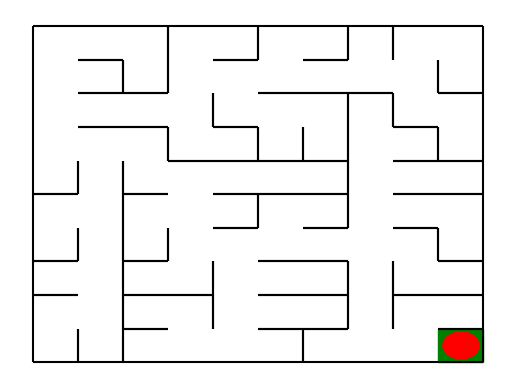

Maze of size (10, 10)


In [8]:
# ==================== 测试搜索算法 ====================
# 初始化迷宫，设置迷宫大小为10x10
maze = Maze(maze_size=10)  # 从文件或预设生成迷宫对象

# 使用 A* 搜索算法在迷宫中寻找从起点到终点的最短路径
path_2 = my_search(maze)
print("搜索出的路径：", path_2)  # 打印搜索到的路径（动作序列）

# 根据 A* 算法返回的路径依次移动机器人
for action in path_2:
    maze.move_robot(action)  # 执行动作，将机器人在迷宫中移动

# 检查机器人是否到达目标位置
if maze.sense_robot() == maze.destination:
    print("恭喜你，到达了目标点")  # 打印成功信息

# 输出当前迷宫的状态，包括机器人的位置和路径
print(maze)

## 3 基于 DQN 算法

本实验旨在使用深度强化学习中的深度Q网络（DQN）算法，编程实现机器人在迷宫中自动寻找从起点到终点的最优路径。以下是详细的代码实现和解释。

### 3.1 导入必要的库

In [9]:
import os
import random
import numpy as np
from Maze import Maze               # 迷宫环境类
from Runner import Runner
from QRobot import QRobot
from ReplayDataSet import ReplayDataSet
from torch_py.MinDQNRobot import MinDQNRobot as TorchRobot  # PyTorch版本的机器人
# from keras_py.MinDQNRobot import MinDQNRobot as KerasRobot  # Keras版本的机器人
import matplotlib.pyplot as plt
import torch
import time

### 3.2 定义机器人类

 + 定义了一个 Robot 类，继承自 TorchRobot 类。

 + __init__ 方法用于初始化机器人对象，设置迷宫环境和模型参数。

 + 使用 super() 调用父类的初始化方法，确保父类的属性和方法被正确初始化。

 + 调用 maze.set_reward() 方法，设置迷宫的奖励机制，包括撞墙惩罚、到达终点奖励和默认奖励，这些值根据迷宫大小进行调整。

 + 将迷宫对象保存为 self.maze，方便后续使用。

 + 设置探索率 epsilon 为 0，表示在训练和测试中采用贪心策略，始终选择当前估计最优的动作。

 + 设置计算设备 self.device，如果有可用的 GPU（CUDA），则使用 GPU，否则使用 CPU。

 + 调用 self.memory.build_full_view(maze=maze) 开启全图视野，构建经验回放池，这样可以加速训练过程。

 + 将评估网络 eval_model 和目标网络 target_model 迁移到指定的计算设备上。

 + 调用 self.train() 方法开始训练，并将训练过程中产生的损失值保存到 self.loss_list 中。

### 3.3 定义训练函数

 + train 方法用于训练模型，直到机器人能够成功找到迷宫的出口。

 + 初始化一个空的 loss_list，用于保存每次训练的损失值。

 + 设置批次大小 batch_size 为经验回放池的大小，即每次训练时使用所有的经验数据。

 + 记录训练开始的时间 start，用于计算总的训练时间。

 + 在 while True 循环中，不断执行以下步骤：

    + 调用 _learn(batch=batch_size) 方法，从经验回放池中采样数据进行训练，返回当前的损失值，并将其添加到 loss_list。

    + 重置机器人的位置，准备进行测试。

    + 在限制的步数内（迷宫面积）执行测试，如果机器人在测试中成功到达终点，则打印训练时间并返回损失值列表，结束训练。

  + 这样设计的目的是在训练过程中，不断更新模型参数，直到机器人学会了如何在迷宫中找到出口。

### 3.4 定义训练更新方法

 + train_update 方法用于在训练过程中，根据当前策略选择动作并执行，获取相应的奖励。

 + 首先调用 self.sense_state() 获取当前状态（机器人的位置坐标）。

 + 调用 self._choose_action(state) 方法，根据当前状态选择动作，使用的是 epsilon-greedy 策略（在父类 TorchRobot 中实现）。

 + 执行选定的动作，调用 self.maze.move_robot(action)，并获取执行后的奖励 reward。

 + 更新 epsilon 的代码被注释掉，因为在初始化时已经将 epsilon 固定为 0，不再需要更新。

 + 返回选择的动作和获得的奖励。

### 3.5 定义测试更新方法

 + test_update 方法用于在测试过程中，根据当前策略选择动作并执行，获取相应的奖励。

 + 获取当前状态 state，并将其转换为 PyTorch 的张量形式，确保数据类型和设备与模型匹配。

 + 将模型设置为评估模式 self.eval_model.eval()，防止在测试时更新模型参数。

 + 使用 torch.no_grad() 上下文管理器，停止计算梯度，加快推理速度。

 + 将状态输入到评估模型 self.eval_model(state)，获取对应的 Q 值 q_value。

 + 根据 Q 值选择最优动作，这里选择 Q 值最小的动作（因为在迷宫中，奖励是负值，越小越好）。

 + 执行选择的动作，调用 self.maze.move_robot(action)，获取执行后的奖励 reward。

 + 返回选择的动作和获得的奖励。

In [10]:
# ==================== 机器人类定义 ====================
class Robot(TorchRobot):
    def __init__(self, maze):
        """
        初始化 Robot 类，用于在迷宫中执行训练和测试。

        参数:
            maze (Maze): 迷宫对象，用于机器人移动和奖励机制。
        """
        # 调用父类的初始化方法
        super(Robot, self).__init__(maze)
        
        # 设置迷宫的奖励值，确保在较大迷宫中，奖励值足够大以引导机器人到达终点
        maze.set_reward(reward={
            "hit_wall": maze.maze_size * 2.,              # 撞墙时的惩罚，随迷宫大小而增大
            "destination": -maze.maze_size ** 2 * 5.,     # 到达终点的奖励，基于迷宫大小调整
            "default": maze.maze_size * 0.5,              # 每步的默认奖励，微小正值，随迷宫大小而增大
        })
        
        # 记录迷宫对象
        self.maze = maze
        
        # 设置初始探索率 epsilon 为 0，表示完全利用策略
        self.epsilon = 0
        
        # 设置计算设备为 CUDA 或 CPU，加速计算
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # 开启全图视野（“金手指”），构建训练的经验回放池
        self.memory.build_full_view(maze=maze)
        
        # 将模型迁移到所选设备上
        self.eval_model = self.eval_model.to(self.device)
        self.target_model = self.target_model.to(self.device)  # 确保目标网络也迁移到同一设备上
        
        # 开始训练并记录训练过程中产生的损失值
        self.loss_list = self.train()

    # ==================== 训练函数 ====================
    def train(self):
        """
        训练模型直到机器人能够成功找到迷宫出口。

        返回:
            list: 训练过程中产生的损失值列表。
        """
        # 初始化损失值列表
        loss_list = []
        
        # 设置批次大小为经验回放池的大小
        batch_size = len(self.memory)
        
        # 记录训练开始时间
        start = time.time()
        
        # 不断训练直至机器人成功走出迷宫
        while True:
            # 从回放池中采样训练，并记录当前轮次的损失值
            loss = self._learn(batch=batch_size)
            loss_list.append(loss)
            
            # 每轮训练后重置机器人位置，测试是否成功到达终点
            self.reset()
            
            # 限制最大移动步数为迷宫面积
            for _ in range(self.maze.maze_size ** 2):
                action, reward = self.test_update()
                
                # 如果奖励值等于到达终点的奖励，则成功找到出口
                if reward == self.maze.reward["destination"]:
                    print('Training time: {:.2f} s'.format(time.time() - start))  # 打印总训练时间
                    return loss_list  # 返回损失值列表，结束训练

    # ==================== 训练更新方法 ====================
    def train_update(self):
        """
        训练过程中调用的更新方法，用于选择动作并获得对应的奖励。

        返回:
            tuple: (action, reward)，选择的动作及执行后的奖励。
        """
        # 获取当前状态（机器人的位置）
        state = self.sense_state()
        
        # 根据当前状态选择动作，遵循 epsilon-greedy 策略（TorchRobot 中实现）
        action = self._choose_action(state)
        
        # 执行选择的动作，并获取对应的奖励
        reward = self.maze.move_robot(action)

        # 更新 epsilon 值以逐步减少探索（注释掉，因为 epsilon 固定为 0）
        # self.epsilon = max(0.01, self.epsilon * 0.995)

        # 返回动作和对应的奖励
        return action, reward

    # ==================== 测试更新方法 ====================
    def test_update(self):
        """
        测试过程中调用的更新方法，使用当前策略选择动作并执行。

        返回:
            tuple: (action, reward)，选择的动作及执行后的奖励。
        """
        # 获取当前状态，并转换为 PyTorch 张量，确保与模型输入格式一致
        state = np.array(self.sense_state(), dtype=np.int16)
        state = torch.from_numpy(state).float().to(self.device)  # 确保数据在同一设备上

        # 设置模型为评估模式，停止参数更新
        self.eval_model.eval()
        
        # 停止计算图，以加快推理速度
        with torch.no_grad():
            # 通过模型获取当前状态对应的 Q 值
            q_value = self.eval_model(state).cpu().data.numpy()

        # 选择 Q 值最小的动作（TorchRobot 的规则），返回动作
        action = self.valid_action[np.argmin(q_value).item()]
        
        # 执行选择的动作，并获取对应的奖励
        reward = self.maze.move_robot(action)
        
        # 返回动作和奖励
        return action, reward

### 3.6 迷宫和机器人初始化以及路径测试

 + 设置迷宫的大小 maze_size ，创建一个迷宫对象 maze。

 + 创建一个机器人对象 robot，并将迷宫传入其中。

 + 打印迷宫的奖励机制，以便了解各个动作的奖励值。

 + 重置机器人的位置，准备进行测试。

 + 在限制的步数内（迷宫面积）循环，调用 robot.test_update() 执行动作并获取奖励。

 + 打印每一步的动作和对应的奖励。

 + 如果在某一步中，获得的奖励等于到达终点的奖励，则表示机器人成功找到出口，打印提示信息并退出循环。

In [11]:
# ==================== 迷宫和机器人初始化和路径测试 ====================
maze_size = 7  # 设置迷宫大小
maze = Maze(maze_size=maze_size)
robot = Robot(maze=maze)

# 打印当前迷宫的奖励机制，观察不同动作对应的奖励值
print("迷宫奖励机制:", robot.maze.reward)

# 测试机器人是否能根据当前策略找到终点
robot.reset()  # 重置机器人的位置
for _ in range(maze.maze_size ** 2):  # 限制最大移动步数，避免死循环
    action, reward = robot.test_update()  # 执行动作并获取奖励
    print("动作:", action, "奖励:", reward)
    
    # 如果获得终点奖励，表示成功找到出口
    if reward == maze.reward["destination"]:
        print("成功到达终点！")
        break

Training time: 7.17 s
迷宫奖励机制: {'hit_wall': 14.0, 'destination': -245.0, 'default': 3.5}
动作: d 奖励: 3.5
动作: d 奖励: 3.5
动作: r 奖励: 3.5
动作: r 奖励: 3.5
动作: r 奖励: 3.5
动作: r 奖励: 3.5
动作: d 奖励: 3.5
动作: r 奖励: 3.5
动作: d 奖励: 3.5
动作: d 奖励: 3.5
动作: d 奖励: 3.5
动作: r 奖励: -245.0
成功到达终点！


### 3.7 DQN算法训练并绘制训练结果

 + 设置训练 epoch training_per_epoch

 + 创建一个 Runner 实例 runner，用于管理训练过程。

 + 调用 runner.run_training(epoch, training_per_epoch) 开始训练。

 + 训练完成后，绘制训练过程中损失值的变化曲线。

 + 使用 plt.plot(robot.loss_list) 绘制损失值列表，添加坐标轴标签和标题，然后显示图像。

 + 调用 runner.plot_results() 显示完整的训练结果，包括机器人在迷宫中的路径和策略效果。


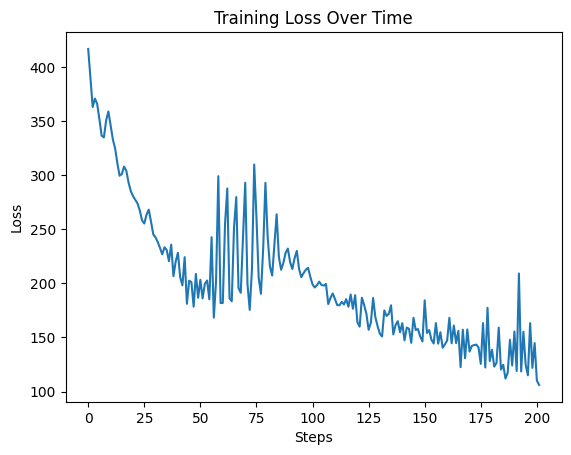

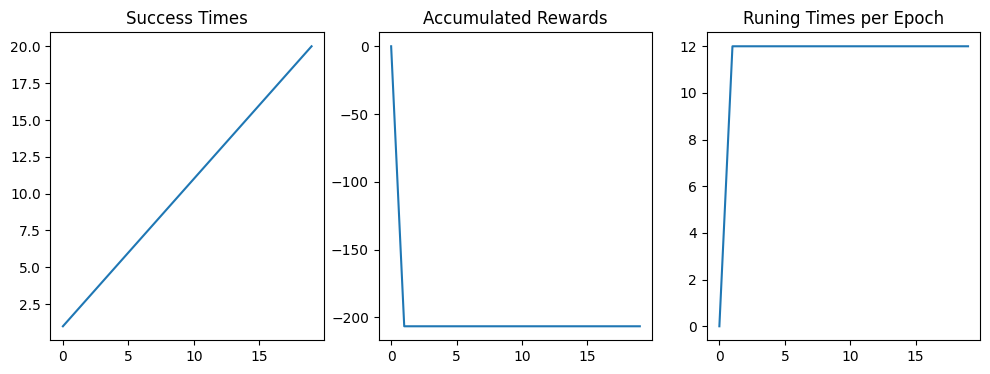

In [12]:
# ==================== DQN算法训练并绘制训练结果 ====================
epoch = 20  # 训练轮数
training_per_epoch = maze_size * maze_size * 5  # 每轮训练的步数
runner = Runner(robot)  # 创建 Runner 实例进行训练管理
runner.run_training(epoch, training_per_epoch)  # 开始训练

plt.plot(robot.loss_list)  # 绘制损失列表
plt.xlabel("Steps")        # x轴标签为“步数”
plt.ylabel("Loss")         # y轴标签为“损失”
plt.title("Training Loss Over Time")  # 图标题为“训练损失变化曲线”
plt.show()  # 显示绘图

runner.plot_results()  # 显示完整训练结果，包括路径规划和策略效果等